# Rule Extraction and XAI metrics

### **Prepare environment**

In [ ]:
!pip install kmodes==0.11.1
!pip install aix360==0.2.1
!pip install alibi==0.3.2
!pip install arff==0.9
!pip install interpret==0.1.20
!pip install numpy==1.20.2
!pip install pandas==1.2.3
!pip install scikit-learn==0.22
!pip install matplotlib==3.3.4
!pip install seaborn==0.11.1
!pip install shapely==1.6.4
!pip install skope-rules==1.0.1
!pip install rulefit==0.3.1
!pip install ruleset==1.0.1

**NOTE**: Remember to *restart* the kernel after installing the libraries in order to avoid import issues

In [1]:
from platform import python_version

print(python_version())

3.7.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import library
import os, sys 

#f_folder = os.getcwd()
f_folder = "/content/drive/MyDrive/Colab Notebooks/rule_extraction_xai/code"
#f_path_lib = os.path.join(f_folder, "code")
f_path_lib = f_folder
lib_path = os.path.abspath(f_path_lib)
sys.path.append(lib_path)

In [4]:
# Colab only - change directory
%cd "/content/drive/MyDrive/Colab Notebooks/rule_extraction_xai/code"
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/rule_extraction_xai/code
/content/drive/MyDrive/Colab Notebooks/rule_extraction_xai/code


### **Import libraries**

In [5]:
import numpy as np
import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from lib.xai_auxiliary_rule_extraction import generateRuleHypercubes
from lib.xai_rule_metrics import (
  checkFidelity, 
  checkStability,
  checkDiversity
   )
from lib.xai_tools import plot_2D, loadDatasets

### 1. Load Data & Get Anomalies

In [6]:
# Load data
df_input, _, _ = loadDatasets(f_name = "seismic-bumps")
numerical_cols = ["gdenergy", "gdpuls"]  # 2D
categorical_cols = []
df_input = (df_input[numerical_cols + categorical_cols + ['target_class']]
            .drop_duplicates(subset = numerical_cols + categorical_cols)
            )
df_input.head()

,gdenergy,gdpuls,target_class
0,-72,-72,1
1,-70,-79,1
2,-81,-78,1
3,-23,40,1
4,-63,-52,1


In [7]:
# Train model & Get predictions
df_train = df_input.copy().drop(columns=['target_class'])
clf = IsolationForest()
y_pred_train = clf.fit_predict(df_train)
dist = clf.decision_function(df_train)
df_anomalies = df_input.copy()
df_anomalies["predictions"] = y_pred_train
df_anomalies["dist"] = dist
df_anomalies["score"] = clf.decision_function(df_train)
df_anomalies.head()

,gdenergy,gdpuls,target_class,predictions,dist,score
0,-72,-72,1,1,0.024128,0.024128
1,-70,-79,1,1,0.006284,0.006284
2,-81,-78,1,-1,-0.010667,-0.010667
3,-23,40,1,1,0.027570,0.027570
4,-63,-52,1,1,0.058245,0.058245


In [8]:
# Paths
path_folder = "pruebasIF"
file_template = "DT_IF"

method = "DecisionTree"
# list_methods = ["DecisionTree", "RuleFit", "FRL", "SkopeRules", "DecisionRuleList", "brlg", "logrr"]

### 2. Get Rules as Hypercubes

In [9]:
## 1. Get Rules (Hypercube)
# Define hyperparams for the XAI model
model_params = {}
# Generate rules hypercubes
df_rules_inliers, df_rules_outliers = generateRuleHypercubes(
    df_anomalies = df_anomalies,
    numerical_cols = numerical_cols,
    categorical_cols = categorical_cols,
    method = method,
    simplify_rules = True,
    model_params = model_params,
)
df_rules_inliers.head()

Depth tree:  14
Nodes tree:  95
leaf nodes not anomalies:  47
tree rules not anomalies:  24
tree rules anomalies:  17
Turning rules to hypercubes...
Prunning the rules obtained...
Iter 0/20
Iter 1/20
Iter 2/20
Iter 3/20
Iter 4/20
Iter 5/20
Iter 6/20
Iter 7/20
Iter 8/20
Iter 9/20
Iter 10/20
Iter 11/20
Iter 12/20
Iter 13/20
Iter 14/20
Iter 15/20
Iter 16/20
Iter 17/20
Iter 18/20
Iter 19/20
No more improvements... finishing up
Turning rules to hypercubes...
Prunning the rules obtained...
Iter 0/25
Iter 1/25
Iter 2/25
Iter 3/25
Iter 4/25
Iter 5/25
Iter 6/25
Iter 7/25
Iter 8/25
Iter 9/25
Iter 10/25
Iter 11/25
Iter 12/25
Iter 13/25
Iter 14/25
Iter 15/25
Iter 16/25
Iter 17/25
Iter 18/25
Iter 19/25
Iter 20/25
Iter 21/25
Iter 22/25
Iter 23/25
Iter 24/25
No more improvements... finishing up


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction
index,,,,,,
14,124.5,-inf,63.0,-73.5,6,1
1,-63.5,-79.5,-73.5,-79.5,6,1
8,94.5,-79.5,97.5,-64.5,8,1
7,124.5,124.5,97.5,-73.5,6,1
10,-64.0,-76.0,-79.5,-81.5,6,1


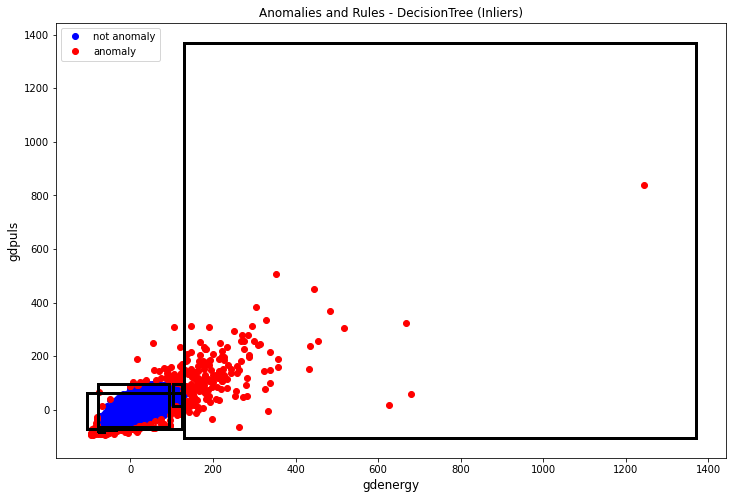

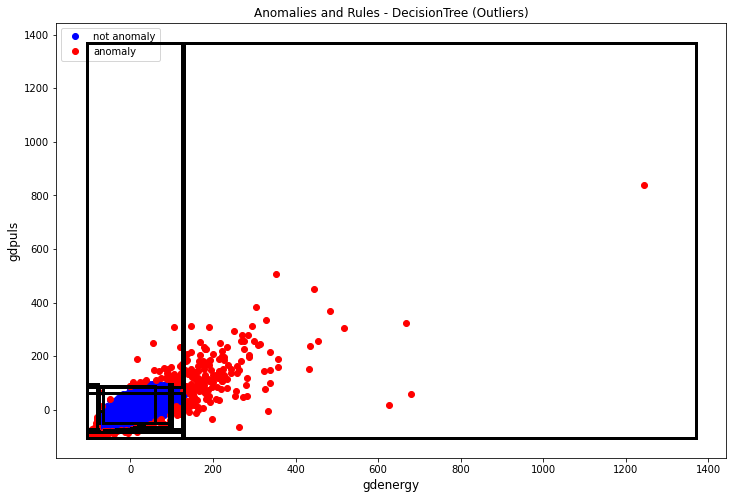

In [10]:
## 2. Plot Results [Only for 2D]
max_replace = df_input.max().max() + np.abs(df_input.max().max()) * 0.1
min_replace = df_input.min().min() - np.abs(df_input.min().min()) * 0.1
df_inliers_plot = (
    df_rules_inliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
) 
df_outliers_plot = (
    df_rules_outliers.copy()
    .replace(np.inf, max_replace)
    .replace(-np.inf, min_replace)
)

plot_2D(df_inliers_plot, df_anomalies, title = method + ' (Inliers)')
plot_2D(df_outliers_plot, df_anomalies, title = method + ' (Outliers)')

### 3. XAI Metrics

In [11]:
# Precision (unsupervised model predictions vs ground truth)
target_names = ['outliers', 'inliers']
y_true = df_anomalies['target_class']
y_pred = df_anomalies['predictions']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    outliers       0.22      0.34      0.27       229
     inliers       0.93      0.87      0.90      2143

    accuracy                           0.82      2372
   macro avg       0.57      0.61      0.58      2372
weighted avg       0.86      0.82      0.84      2372



In [12]:
# Comprehensibility
n_rules_inliers = len(df_rules_inliers)
n_rules_outliers = len(df_rules_outliers)
mean_rule_size_inliers = df_rules_inliers['size_rules'].mean()
mean_rule_size_outliers = df_rules_outliers['size_rules'].mean()

In [13]:
# Fidelity/Representativeness/Focus on Abnormal
df_rules_inliers, df_rules_outliers, df_anomalies = checkFidelity(
    df_anomalies, df_rules_inliers, df_rules_outliers, numerical_cols, 
    categorical_cols
    )
df_rules_inliers.head()

Getting rule predictions...
Iter 0/2372
Iter 500/2372
Iter 1000/2372
Iter 1500/2372
Iter 2500/2372

Getting rule coverage...
Iter 0/2372
Iter 500/2372
Iter 1000/2372
Iter 1500/2372
Iter 2500/2372


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal
index,,,,,,,,,,,,,,,,,
14,124.5,-inf,63.0,-73.5,6,1,1857,47,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105
1,-63.5,-79.5,-73.5,-79.5,6,1,16,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105
8,94.5,-79.5,97.5,-64.5,8,1,1867,16,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105
7,124.5,124.5,97.5,-73.5,6,1,0,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105
10,-64.0,-76.0,-79.5,-81.5,6,1,2,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105


In [14]:
# Stability
df_rules_inliers = checkStability(
  df_anomalies,
  df_rules_inliers,
  clf,
  numerical_cols, 
  categorical_cols,
  using_inliers = True
  )
df_rules_outliers = checkStability(
  df_anomalies,
  df_rules_outliers,
  clf,
  numerical_cols, 
  categorical_cols,
  using_inliers = False
  )
df_rules_inliers.head()

,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal,stability_score
index,,,,,,,,,,,,,,,,,,
14,124.5,-inf,63.0,-73.5,6,1,1857,47,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98
1,-63.5,-79.5,-73.5,-79.5,6,1,16,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98
8,94.5,-79.5,97.5,-64.5,8,1,1867,16,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98
7,124.5,124.5,97.5,-73.5,6,1,0,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98
10,-64.0,-76.0,-79.5,-81.5,6,1,2,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98


In [15]:
# Diversity
df_rules_inliers, _ = checkDiversity(
  df_rules_inliers, 
  numerical_cols, 
  categorical_cols
  )
df_rules_outliers, _ = checkDiversity(
  df_rules_outliers, 
  numerical_cols, 
  categorical_cols
  )
df_rules_inliers.head()

Iter 1/1
Iter 1/1


,gdenergy_max,gdenergy_min,gdpuls_max,gdpuls_min,size_rules,rule_prediction,n_inliers_included,n_outliers_included,n_inliers,n_inliers_p0,n_inliers_p1,precision_rules,recall_rules,f1_rules,precision_rules_abnormal,recall_rules_abnormal,f1_rules_abnormal,stability_score,diversity_score
index,,,,,,,,,,,,,,,,,,,
14,124.5,-inf,63.0,-73.5,6,1,1857,47,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98,0.976315
1,-63.5,-79.5,-73.5,-79.5,6,1,16,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98,0.976315
8,94.5,-79.5,97.5,-64.5,8,1,1867,16,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98,0.976315
7,124.5,124.5,97.5,-73.5,6,1,0,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98,0.976315
10,-64.0,-76.0,-79.5,-81.5,6,1,2,0,2027,2002,54,0.897758,0.987667,0.893339,0.008333,1.0,0.217105,0.98,0.976315
